In [1]:
#Includes necesarios
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,plot_roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import auxiliar as aux
from preprocessing import apply_OHE, init_OHE, init_dataset, standarize, normalize, scale, eliminar_features, reduce_by_frequency

# KNN

Los hiperparametros que consideramos relevantes para un modelo como el de KNN (k-nearest neighbors) son:
   - n_neighbors (K): cantidad de vecinos, se aconseja que sea impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos
   - weights: El peso que se le da a la distancia entre los puntos.
   - metric: La funcion para calcular la distancia entre los puntos.

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [2]:
X,y = aux.get_train_set()
X = init_dataset(X)

## Preprocesamiento 1: Eliminación de Features + Reducción por Frecuencia + OHE + Estandarización 

Primero eliminamos los features que consideramos que no aportan información y agrupamos las categorias con menos del 5% de los datos en una sola. Luego aplicamos OHE a las columnas categóricas y estandarización:

In [3]:
X_p1 = eliminar_features(X, ['religion', 'barrio', 'categoria_de_trabajo'])
X_p1 = reduce_by_frequency(X_p1, ['estado_marital', 'trabajo'], 0.05)

In [4]:
init_OHE(X_p1)
X_p1 = apply_OHE(X_p1)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento. Realizamos este primer paso ya que queremos evitar un dataleaking a causa que estamos calculando media y desviacion estandar con los datos de validacion:

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p1, y, test_size=0.2, stratify=y, random_state=0)

In [6]:
X_train = standarize(X_train)
X_validation = standarize(X_validation)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos
    - Para el numero de vecinos se analizo el intervalo de (5, 500) y se concluyó que el mejor resultado se obtiene en el rango mostrado en el GridSearch

In [7]:
parameters = {
    'n_neighbors': [31, 43, 53, 61],
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree']
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True, verbose=True
).fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [8]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8863114415032463
Mejores Parametros {'algorithm': 'kd_tree', 'n_neighbors': 43, 'weights': 'uniform'}

Mejor score ROC-AUC en Validación: 0.8861848961020202


Armamos el modelo de KNN con los hiperparametros calculados:

In [9]:
model_knn_standarize = gscv.best_estimator_
model_knn_standarize

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=43)

Predecimos con el validation set:

In [10]:
knn_predict = model_knn_standarize.predict(X_validation)

**Metricas**

In [11]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4945
           1       0.70      0.51      0.59      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



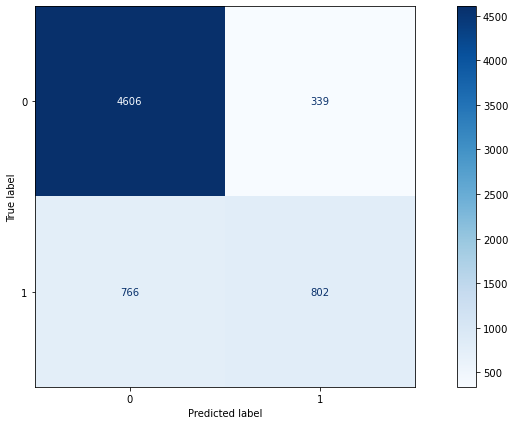

In [12]:
aux.plot_cm(model_knn_standarize, X_validation, y_validation)

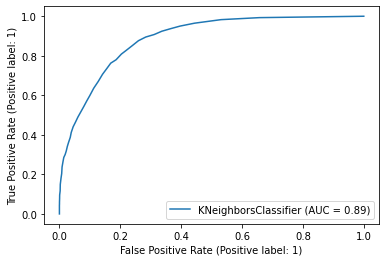

In [13]:
plot_roc_curve(model_knn_standarize, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 2: Eliminación de Features + Reducción por Frecuencia + OHE + Escalado 

Probaremos ahora como es el rendimiento del modelo KNN utilizando el mismo preprocesamiento pero aplicando un escalado de nuestras columnas en lugar de la estandarización. El rango de escalado es entre (0,1).

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento. Realizamos este primer paso ya que queremos evitar un dataleaking a causa que estamos calculando media y desviacion estandar con los datos de validacion:

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p1, y, test_size=0.2, stratify=y, random_state=0)

In [15]:
X_train = scale(X_train)
X_validation = scale(X_validation)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos
    - Para el numero de vecinos se analizo el intervalo de (5, 500) y se concluyó que el mejor resultado se obtiene en el rango mostrado en el GridSearch

In [16]:
parameters = {
    'n_neighbors': [31, 43, 53, 61],
    'weights': ['uniform','distance'],
    'algorithm': ['kd_tree']
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [17]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8810315152225277
Mejores Parametros {'algorithm': 'kd_tree', 'n_neighbors': 43, 'weights': 'uniform'}

Mejor score ROC-AUC en Validación: 0.8784915318503539


Armamos el modelo de KNN con los hiperparametros calculados:

In [18]:
model_knn_scale = gscv.best_estimator_
model_knn_scale

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=43)

Predecimos con el validation set:

In [19]:
knn_predict = model_knn_scale.predict(X_validation)

**Metricas**

In [20]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4945
           1       0.69      0.51      0.59      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



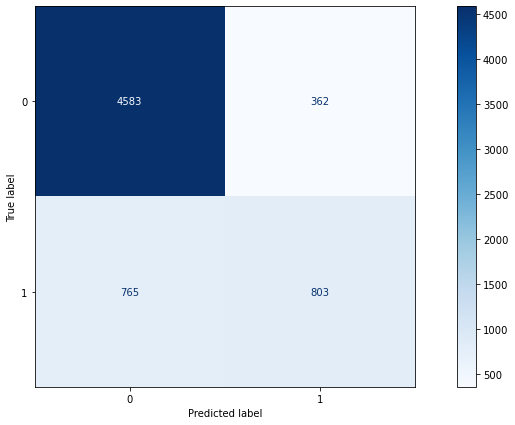

In [21]:
aux.plot_cm(model_knn_scale, X_validation, y_validation)

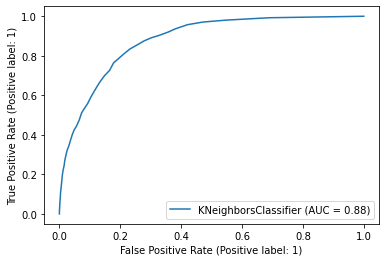

In [22]:
plot_roc_curve(model_knn_scale, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 3: Eliminación de Features + Reducción por Frecuencia + OHE + Normalización

Probaremos ahora como es el rendimiento del modelo KNN aplicando el mismo preprocesamiento y una normalizacion.

In [23]:
X_normalized = normalize(X_p1)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento. En el caso de la normalizacion, no hace falta realizar la particion antes debido a que se hace el calulo por filas y asi no se tiene dataleaking:

In [24]:
X_train, X_validation, y_train, y_validation = train_test_split(X_normalized,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos
    - Para el numero de vecinos se analizo el intervalo de (5, 500) y se concluyó que el mejor resultado se obtiene en el rango mostrado en el GridSearch

In [25]:
parameters = {
    'n_neighbors': [31, 43, 53, 61],
    'weights': ['uniform','distance'],
    'algorithm': ['kd_tree'],
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [26]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8710563327898069
Mejores Parametros {'algorithm': 'kd_tree', 'n_neighbors': 31, 'weights': 'uniform'}

Mejor score ROC-AUC en Validación: 0.8633878918099089


Armamos el modelo de KNN con los hiperparametros calculados:

In [27]:
model_knn_normalized = gscv.best_estimator_
model_knn_normalized

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=31)

Predecimos con el validation set:

In [28]:
knn_predict = model_knn_normalized.predict(X_validation)

**Metricas**

In [29]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      4945
           1       0.66      0.55      0.60      1568

    accuracy                           0.82      6513
   macro avg       0.76      0.73      0.74      6513
weighted avg       0.81      0.82      0.82      6513



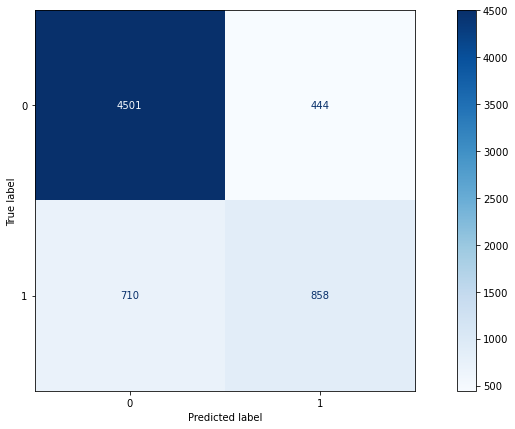

In [30]:
aux.plot_cm(model_knn_normalized, X_validation, y_validation)

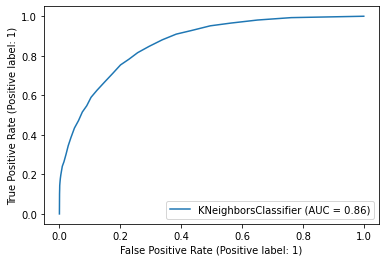

In [31]:
plot_roc_curve(model_knn_normalized, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h1>Predicción</h1>

In [32]:
ids, X_holdout = aux.get_holdout_set()

In [33]:
X_holdout = init_dataset(X_holdout)

In [34]:
X_holdout = eliminar_features(X_holdout, ['religion', 'barrio', 'categoria_de_trabajo'])
X_holdout = reduce_by_frequency(X_holdout, ['estado_marital', 'trabajo'], 0.05)
X_holdout = apply_OHE(X_holdout)
X_holdout = standarize(X_holdout)

In [35]:
model_knn_pred = model_knn_standarize.predict(X_holdout)

In [36]:
aux.create_prediction(ids, model_knn_pred, file_name='knn')